In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import sys
sys.path.insert(0,'../')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+37699fa torch: 0.3.0.post4 cuda: True


In [2]:
from functools import wraps

# TODO: move this into probtorch.util
def expand_inputs(f):
    @wraps(f)
    def g(*args, num_samples=None, **kwargs):
        if not num_samples is None:
            new_args = []
            new_kwargs = {}
            for arg in args:
                if hasattr(arg, 'expand'):
                    new_args.append(arg.expand(num_samples, *arg.size()))
                else:
                    new_args.append(arg)
            for k in kwargs:
                arg = kwargs[k]
                if hasattr(arg, 'expand'):
                    new_args.append(arg.expand(num_samples, *arg.size()))
                else:
                    new_args.append(arg)
            return f(*new_args, num_samples=num_samples, **new_kwargs)
        else:
            return f(*args, num_samples=None, **kwargs)
    return g

# Parameters

In [3]:
# Model Paramters:
NUM_LATENT = 64

# Training Parameters:
NUM_SAMPLES = 1
NUM_BATCH = 512
NUM_EPOCHS = 100
LABEL_FRACTION = 0.0
LEARNING_RATE = 1e-3
EPS = 1e-9
CUDA = torch.cuda.is_available()

# LOSS parameters:
ALPHA = 0.1
BETA = (1.0, 1.0, 0.0, 4.0, 1.0) 

# Encoder Model

In [11]:
class Encoder(nn.Module):
    def __init__(self, num_latent=NUM_LATENT):
        super(self.__class__, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),     # 32 x 32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),   # 16 x 16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 4, 2, 1),  # 8 x 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),  # 4 x 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, 4),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Conv2d(512, num_latent, 1),
        )
        self.mu = nn.Conv2d(512, num_latent, 1)
        self.logvar = nn.Conv2d(512, num_latent, 1)

    @expand_inputs
    def forward(self, images, labels=None, num_samples=None):
        q = probtorch.Trace()
        enc = self.enc(images.view(-1, 1, 64, 64))
        mu = self.mu(enc).squeeze()
        logvar = self.logvar(enc).squeeze()
        latent = q.normal(mu, logvar, name='z')  # need to figure out how they set stdev
        return q 

# Decoder Model

In [12]:
def binary_cross_entropy(x_mean, x, EPS=1e-9):
    return - (torch.log(x_mean + EPS) * x + 
              torch.log(1 - x_mean + EPS) * (1 - x)).sum(-1)

class Decoder(nn.Module):
    def __init__(self, num_latent=NUM_LATENT):        
        super(self.__class__, self).__init__()
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(num_latent, 512, 1, 1, 0),  # 1 x 1
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 4, 1, 0),         # 4 x 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),         # 8 x 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 128, 4, 2, 1),         # 16 x 16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),          # 32 x 32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1)             # 64 x 64
        )
        
        
    def forward(self, images, q=None, num_samples=None):
        p = probtorch.Trace()
        b_size = images.size(0)
        latent = p.normal(0.0, 1.0, value=q['z'], name='z')
        images_mean = self.dec(latent.view(b_size, -1, 1, 1)).view(b_size, 1, 64, 64).sigmoid()
        p.loss(binary_cross_entropy, images_mean, images, name='images')
        return p

# Loss

In [13]:
def elbo(q, p, alpha=ALPHA, beta=BETA):
    return probtorch.objectives.montecarlo.elbo(q, p, alpha=alpha, beta=beta[0])

# Data

In [14]:
from torchvision import datasets, transforms
import os 
DATA_PATH = '../data/3dfaces/'

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_d = torch.load(DATA_PATH + 'train_data.rar')
test_d = torch.load(DATA_PATH + 'test_data.rar')

train_data = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(train_d, torch.Tensor(train_d.size(0), 1)),
                batch_size=NUM_BATCH, shuffle=True)
test_data = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(test_d, torch.Tensor(test_d.size(0), 1)),
                batch_size=NUM_BATCH, shuffle=True) 

# Training and Testing

In [15]:
enc = Encoder()
dec = Decoder()
if CUDA:
    enc.cuda()
    dec.cuda()
optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                              lr=LEARNING_RATE)


In [16]:
def train(data, enc, dec, optimizer, 
          label_mask={}, label_fraction=LABEL_FRACTION):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    for b, (images, labels) in enumerate(data):        
        #images = images.view(-1, NUM_PIXELS)
        if CUDA:
            images = images.cuda()
        images = Variable(images)
        optimizer.zero_grad()
        if b not in label_mask:
            label_mask[b] = (random() < label_fraction)
        if label_mask[b]:
            labels_onehot = torch.zeros(NUM_BATCH, 1)
            #labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
            #labels_onehot = torch.clamp(labels_onehot, EPS, 1-EPS)
            #labels_onehot = Variable(labels_onehot)
            if CUDA:
                labels_onehot = labels_onehot.cuda()
            q = enc(images, labels_onehot, num_samples=NUM_SAMPLES)
        else:
            q = enc(images, num_samples=NUM_SAMPLES)
        p = dec(images, q, num_samples=NUM_SAMPLES)
        loss = -elbo(q, p)
        loss.backward()
        optimizer.step()
        if CUDA:
            loss = loss.cpu()
        epoch_elbo -= loss.data.numpy()[0]
    return epoch_elbo / len(train_data.dataset), label_mask


def test(data, enc, dec, infer=True):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    epoch_correct = 0
    N = len(test_data.dataset)
    for b, (images, labels) in enumerate(data):
        if CUDA:
            images = images.cuda()
        images = Variable(images)
        q = enc(images, num_samples=NUM_SAMPLES)
        p = dec(images, q, num_samples=NUM_SAMPLES)
        batch_elbo = elbo(q, p)
        if CUDA:
            batch_elbo = batch_elbo.cpu()
        epoch_elbo += batch_elbo.data.numpy()[0]

    return epoch_elbo / N, epoch_correct / N


In [17]:
import time
from random import random

train_elbo_dict = {'ELBO':[], 'Recun Loss': [], 'TC': [], 'PriorZ':[], 'PriorY':[], 'MI':[]}
test_elbo_dict = {'ELBO':[], 'Recun Loss': [], 'TC': [], 'PriorZ':[], 'PriorY':[], 'MI':[]}
test_acc_list = []
mask = {}
for e in range(NUM_EPOCHS):
    train_start = time.time()
    train_elbo, mask = train(train_data, enc, dec, 
                             optimizer, mask, LABEL_FRACTION)
    train_end = time.time()
    test_start = time.time()
    test_elbo, test_accuracy = test(test_data, enc, dec)
    test_end = time.time()
    
    test_acc_list.append(test_accuracy)
    print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e, Accuracy %0.3f (%ds)' % (
            e, train_elbo, train_end - train_start, 
            test_elbo, test_accuracy, test_end - test_start))

[Epoch 0] Train: ELBO -1.6265e+03 (53s) Test: ELBO -1.7814e+03, Accuracy 0.000 (8s)
[Epoch 1] Train: ELBO -1.5535e+03 (53s) Test: ELBO -1.5773e+03, Accuracy 0.000 (9s)
[Epoch 2] Train: ELBO -1.5408e+03 (54s) Test: ELBO -1.5294e+03, Accuracy 0.000 (9s)
[Epoch 3] Train: ELBO -1.5762e+03 (54s) Test: ELBO -1.5624e+03, Accuracy 0.000 (9s)
[Epoch 4] Train: ELBO -1.5487e+03 (54s) Test: ELBO -1.5409e+03, Accuracy 0.000 (8s)
[Epoch 5] Train: ELBO -1.5638e+03 (54s) Test: ELBO -1.5570e+03, Accuracy 0.000 (9s)
[Epoch 6] Train: ELBO -1.5462e+03 (53s) Test: ELBO -1.5472e+03, Accuracy 0.000 (9s)
[Epoch 7] Train: ELBO -1.5370e+03 (54s) Test: ELBO -1.5542e+03, Accuracy 0.000 (9s)
[Epoch 8] Train: ELBO -1.5385e+03 (54s) Test: ELBO -1.5605e+03, Accuracy 0.000 (9s)
[Epoch 9] Train: ELBO -1.5463e+03 (54s) Test: ELBO -1.5528e+03, Accuracy 0.000 (9s)
[Epoch 10] Train: ELBO -1.5435e+03 (54s) Test: ELBO -1.5305e+03, Accuracy 0.000 (9s)
[Epoch 11] Train: ELBO -1.5307e+03 (55s) Test: ELBO -1.5362e+03, Accuracy 0

KeyboardInterrupt: 

# Visualise Reconstructions

In [19]:
from torchvision.utils import make_grid

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 2))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.tight_layout()

test_DL = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(test_d, torch.zeros(test_d.size(0), 1)),
            batch_size=15, shuffle=True) 

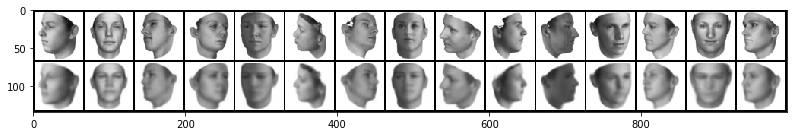

In [20]:
for i, (images, _) in enumerate(test_DL):
    if CUDA:
        images = images.cuda()
    images = Variable(images)
    q = enc(images, num_samples=NUM_SAMPLES)
    p = dec(images, q, num_samples=NUM_SAMPLES)
    recon = p['images'].value
    break

show(make_grid(torch.cat([images, recon], 0).data.cpu(), nrow=15))

# Visualize Encodings

In [ ]:
# Get all the embeddings
Zs = []
for b, (images, labels) in enumerate(train_data):
    enc.eval()
    if CUDA:
        images = images.cuda()
    images = Variable(images, volatile=True)
    q = enc(images, num_samples=NUM_SAMPLES)
    Zs.append(q['z'].value)

Zs = torch.cat(Zs, 0).data.squeeze().cpu().numpy()

In [ ]:
f, axarr = plt.subplots(NUM_LATENT, NUM_LATENT, figsize=(30, 30), sharex=True)
f.suptitle(r'$Z \ Embeddings$' , fontsize=30)

for i in range(NUM_LATENT):
    axarr[NUM_LATENT-1,i].set_xlabel(r'$\mathbf{z_{%d}}$' % i, fontsize=10)
    axarr[i,0].set_ylabel(r'$\mathbf{z_{%d}}$' % i, fontsize=10)
    for j in range(NUM_LATENT):
        if i==j:
            axarr[j,i].hist(Zs[:,i], bins=40)
        else:
            axarr[j,i].scatter(Zs[:,i],Zs[:,j],alpha=0.5)
            
plt.show()

# Go no further!!

# Let's see some Features!

In [ ]:
def vary_z2(index, zmin, zmax):
    f, axarr = plt.subplots(10,10,figsize=(10,10),sharey=True)
    f.suptitle(r'$\mathbf{z_{%d}} \ \  varying$' % index , fontsize=30)
    z_range = np.linspace(zmin,zmax,num=10)
    
    for i in range(10):
        for j in range(10):
            z = torch.zeros(1,10)
            z[0,index] = z_range[i]
            z = Variable(z.cuda())
            null_image = Variable(torch.Tensor(np.zeros((1, 784)))).cuda()
            y_hot = np.zeros((1,10))
            y_hot[0,j] = 1
            y_hot = Variable(torch.FloatTensor(y_hot).cuda())
            q_null = {'z': z, 'y':y_hot}
            p = dec(null_image, q_null, num_samples=NUM_SAMPLES) 
            image = p['images']
            image = image.value.cpu().data.numpy().reshape(28,28)
            axarr[i,j].imshow(image)
            axarr[i,j].axis('off')
            
    return None

for style in range(NUM_STYLE):
    vary_z2(style, -3, 3)
    plt.show()

1. feature 0: Horizontal angles (look at 3 ,4, and 7)
2. feature 1: Y-position of the middle line (look at 4 middle line)
3. feature 2: Width
4. feature 3: Nothing
5. feature 4: Angle 
6. feature 5: Nothing
7. feature 6: Stroke
8. feature 7: Not sure
9. feature 8: Top circle gets bigger, the other one smaller
10. feature 9: Nothing

## Features $z_{i}$ vs $z_{j}$ for Digits:

In [ ]:
def zi_vs_zj(z_index1, z_index2, zmin=3, zmax=3, num_z=10, digit=0):
    f, axarr = plt.subplots(num_z, num_z, figsize=(num_z, num_z), sharey=True)
    f.suptitle(r'$Digit: %s$' % digit , fontsize=30)
    z_range = np.linspace(zmin,zmax,num=num_z)
    
    for i in range(num_z):
        for j in range(num_z):
            z = torch.zeros(1,NUM_STYLE)
            z[0,z_index1] = z_range[i]
            z[0,z_index2] = z_range[j]
            z = Variable(z.cuda())
            y_hot = np.zeros((1,NUM_DIGITS))
            y_hot[0,digit] = 1
            y_hot = Variable(torch.FloatTensor(y_hot).cuda())
            q_null = {'z':z, 'y':y_hot}
            null_image = Variable(torch.Tensor(np.zeros((1, NUM_PIXELS)))).cuda()
            p = dec(null_image, q_null, num_samples=NUM_SAMPLES) 
            image = p['images']
            pixels = int(np.sqrt(NUM_PIXELS))
            image = image.value.cpu().data.numpy().reshape(pixels,pixels)
            axarr[i,j].imshow(image)
            axarr[i,j].axis('off')
    f.text(0.52, 0.08, r'$\mathbf{z_{%d}}$' % z_index2, ha='center', fontsize=20)
    f.text(0.09, 0.5, r'$\mathbf{z_{%d}}$' % z_index1, va='center', rotation='vertical', fontsize=20)

In [ ]:
z_index1 = 6
z_index2 = 4
for digit in range(NUM_DIGITS):
    zi_vs_zj(z_index1, z_index2, zmin=-3, zmax=3, num_z=10, digit=digit)
    plt.show()

## Track terms Vs iters

In [ ]:
fig = plt.figure(figsize=(20,10))
iters = np.arange(NUM_EPOCHS)
for label in train_elbo_dict:
    plt.plot(iters, train_elbo_dict[label], label=label, linewidth=3)
plt.legend(prop={'size': 20})
plt.xlabel("iter", fontsize=20)
plt.title(" Training Process", fontsize=20)
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,10))
iters = np.arange(NUM_EPOCHS)
for label in test_elbo_dict:
    plt.plot(iters, test_elbo_dict[label], label=label, linewidth=3)
plt.legend(prop={'size': 20})
plt.xlabel("iter", fontsize=20)
plt.title(" Testing Process", fontsize=20)
plt.grid(True)
plt.show()